## Predicting Pro Bowl Quarterbacks: 

Here I merge my combine measureables data with my college statistics data. I then drop the Bench and 3Cone columns as they have a signifigant amount NA values.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier
import seaborn as sns


qb_college_stats = pd.read_csv('C:/Users/james/OneDrive/Desktop/nfl_qb_college_stats.csv')
qb_measureables = pd.read_csv('C:/Users/james/OneDrive/Desktop/nfl_combine_qbs.csv')


qb_college_stats['Name'] = qb_college_stats['Name'].astype(str)
qb_measureables['Name'] = qb_measureables['Name'].astype(str)

qb_master_data = pd.merge(qb_measureables, qb_college_stats, on= 'Name', how='inner')

print(len(qb_master_data))
print(qb_master_data.isna().sum())

qb_master_data = qb_master_data.drop(['Bench', '3Cone'], axis=1)

qb_master_data['Pro Bowl'] = qb_master_data['Pro Bowl'].str.strip()



639
Year              0
Name              0
College           0
Position          0
Height (in)       0
Weight (lbs)      0
40YD             80
Bench           603
Vertical        110
Broad Jump      112
Shuttle         133
3Cone           541
BMI               0
G                 0
Cmp               0
Att               0
Cmp%              0
Yds               0
TD                0
TD%               0
Int               0
Int%              0
Y/A               0
AY/A              0
Y/C               0
Y/G               0
Rate              0
Pro Bowl          0
All-Pro           0
MVP               0
dtype: int64


In [2]:
print(qb_master_data['All-Pro'].value_counts())
print(qb_master_data['Pro Bowl'].value_counts())
print(qb_master_data['MVP'].value_counts())
print(qb_master_data.head())

All-Pro
No      630
Yes       9
Name: count, dtype: int64
Pro Bowl
No     567
Yes     72
Name: count, dtype: int64
MVP
No     629
Yes     10
Name: count, dtype: int64
   Year             Name         College Position  Height (in)  Weight (lbs)  \
0  1987  Steve Beuerlein      Notre Dame       QB         74.4           203   
1  1987     Cody Carlson          Baylor       QB         75.0           191   
2  1987   Shawn Halloran  Boston College       QB         76.3           217   
3  1987     Jim Harbaugh        Michigan       QB         74.3           203   
4  1987    Don Majkowski        Virginia       QB         73.5           199   

   40YD  Vertical  Broad Jump  Shuttle  ...  Int  Int%  Y/A  AY/A   Y/C  \
0  5.10      23.0        93.0     4.63  ...   44   5.2  7.7  5.98  13.8   
1  4.82      29.5       111.0     4.45  ...   34   4.8  7.7  6.44  14.8   
2  5.14      23.5        94.0     4.53  ...   31   4.3  7.3  6.16  12.6   
3   NaN       NaN         NaN      NaN  ...   19   3

## Modeling 

Here I impute the missing values with median values. 

In [ ]:

qb_numeric_data = qb_master_data.select_dtypes(include=['number']).columns

median_imputer = SimpleImputer(strategy='median')

qb_master_data[qb_numeric_data] = median_imputer.fit_transform(qb_master_data[qb_numeric_data])


Because the amount of quarterbacks who made the pro bowl is disproportionately less than those who didn't make it. I first stratify the qbs who have made the Pro Bowl.

In [ ]:

qb_X = qb_master_data.iloc[:, [0] + list(range(4, 24))]

qb_y = qb_master_data['Pro Bowl']

qb_y = qb_master_data['Pro Bowl'].replace({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(qb_X, qb_y, test_size=0.2, random_state=42, stratify=qb_y)


C:\Users\james\AppData\Local\Temp\ipykernel_40260\30714843.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  qb_y = qb_master_data['Pro Bowl'].replace({'Yes': 1, 'No': 0})


In [ ]:

model_lg = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000, random_state=42)
model_lg.fit(X_train, y_train)

y_pred_lg = model_lg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lg))
print(classification_report(y_test, y_pred_lg))


Logistic Regression Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       114
           1       0.00      0.00      0.00        14

    accuracy                           0.88       128
   macro avg       0.44      0.49      0.47       128
weighted avg       0.79      0.88      0.83       128



I will set the class weight to balanced to account for the imbalance between Pro Bowl quarterbacks and Non Pro Bowl qbs.

In [6]:

model_lg.set_params(class_weight='balanced')
model_lg.fit(X_train, y_train)
y_pred_lg = model_lg.predict(X_test)
print("Logistic Regression with Class Weight Accuracy:", accuracy_score(y_test, y_pred_lg))
print(classification_report(y_test, y_pred_lg))
print(confusion_matrix(y_test, y_pred_lg))


Logistic Regression with Class Weight Accuracy: 0.6484375
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       114
           1       0.18      0.64      0.29        14

    accuracy                           0.65       128
   macro avg       0.56      0.65      0.53       128
weighted avg       0.85      0.65      0.71       128

[[74 40]
 [ 5  9]]


In [ ]:

# Use RFE to select the top features
rfe = RFE(estimator=model_lg, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Train the model on selected features
model_lg.fit(X_train_rfe, y_train)

# Predict and evaluate
y_pred_rfe = model_lg.predict(X_test_rfe)
print("RFE Accuracy:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))
print(confusion_matrix(y_test, y_pred_rfe))

RFE Accuracy: 0.65625
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       114
           1       0.17      0.57      0.27        14

    accuracy                           0.66       128
   macro avg       0.55      0.62      0.52       128
weighted avg       0.84      0.66      0.72       128

[[76 38]
 [ 6  8]]


The logistic regression model seems to be over sensitive as there is a high number of false positives. Lets move to random forest to see how that performs

In [8]:

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))




Accuracy: 0.8984375
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       114
           1       1.00      0.07      0.13        14

    accuracy                           0.90       128
   macro avg       0.95      0.54      0.54       128
weighted avg       0.91      0.90      0.86       128

Confusion Matrix:
[[114   0]
 [ 13   1]]


Because the class of Pro Bowl quarterbacks is under represented I then oversample this group in hopes of improving my models effectiveness. 

In [31]:
ros = RandomOverSampler(random_state=42, sampling_strategy=0.5)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
rf_classifier.fit(X_resampled, y_resampled)
y_pred_resampled = rf_classifier.predict(X_test)


print("Accuracy after resampling:", accuracy_score(y_test, y_pred_resampled))

print("Classification Report after resampling:")
print(classification_report(y_test, y_pred_resampled))


print("Confusion Matrix after resampling:")
print(confusion_matrix(y_test, y_pred_resampled))

Accuracy after resampling: 0.8984375
Classification Report after resampling:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       114
           1       0.57      0.29      0.38        14

    accuracy                           0.90       128
   macro avg       0.74      0.63      0.66       128
weighted avg       0.88      0.90      0.88       128

Confusion Matrix after resampling:
[[111   3]
 [ 10   4]]


In [ ]:
# Hyperparameter tuning using GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None]
}   

rf_random_search = GridSearchCV(RandomForestClassifier(),
    param_grid=params
)

rf_random_search.fit(X_train, y_train)
best_params = rf_random_search.best_params_
best_score = rf_random_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)



Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.8943460879497429


In [11]:
revised_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
revised_rf_classifier.fit(X_resampled, y_resampled) 

y_pred_revised = revised_rf_classifier.predict(X_test)

print("Revised Accuracy after resampling:", accuracy_score(y_test, y_pred_revised))
print(classification_report(y_test, y_pred_revised))
print("Revised Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_revised))



Revised Accuracy after resampling: 0.890625
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       114
           1       0.50      0.14      0.22        14

    accuracy                           0.89       128
   macro avg       0.70      0.56      0.58       128
weighted avg       0.86      0.89      0.86       128

Revised Confusion Matrix:
[[112   2]
 [ 12   2]]


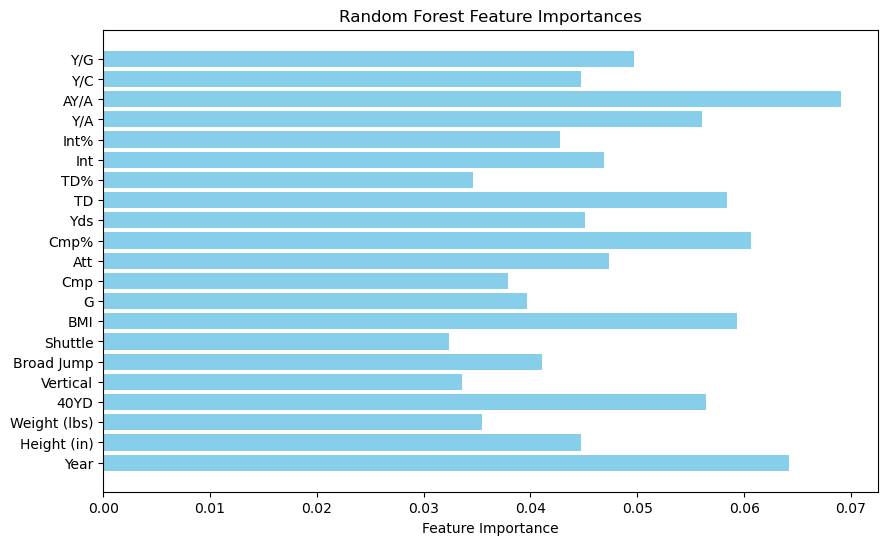

In [ ]:
# Visualizing feature importances

rf_importances = revised_rf_classifier.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(qb_X.columns, rf_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()



Through oversampling and stratifying the precision and accuracy of the random forest performance is slightly improved. Above is graph of feature importance where we can see that adjusted yards per attempt, and Year stand out as the variables that possess the highest feature importance. I will now implement a Balanced Bagging Classifier.

In [ ]:

base_classifier = RandomForestClassifier(random_state=42)



balanced_bagging_classifier = BalancedBaggingClassifier(base_classifier,
														sampling_strategy='majority', 
														replacement=False, 
														random_state=42)

balanced_bagging_classifier.fit(X_resampled, y_resampled)


y_pred = balanced_bagging_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.890625
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       114
           1       0.50      0.21      0.30        14

    accuracy                           0.89       128
   macro avg       0.70      0.59      0.62       128
weighted avg       0.87      0.89      0.87       128

Confusion Matrix:
[[111   3]
 [ 11   3]]


In [ ]:


param_grid = {
    'n_estimators': [10, 50, 100],  
    'sampling_strategy': ['majority', 'not minority', 'auto'],  
    'replacement': [True, False], 
    'max_features':  [0.5, 0.75, 1.0],  
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=balanced_bagging_classifier,
    param_grid=param_grid,
    scoring='f1', 
    cv=5,  
    n_jobs=-1)

grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'max_features': 0.5, 'n_estimators': 10, 'replacement': True, 'sampling_strategy': 'majority'}
Best F1-Score: 0.31758790472710824


In [17]:
balanced_bagging_revised = BalancedBaggingClassifier(**grid_search.best_params_, random_state=42)
balanced_bagging_revised.fit(X_resampled, y_resampled)
y_pred_revised = balanced_bagging_revised.predict(X_test)


print("Revised Accuracy after resampling:", accuracy_score(y_test, y_pred_revised))
print(classification_report(y_test, y_pred_revised))

print("Revised Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_revised))


Revised Accuracy after resampling: 0.8671875
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       114
           1       0.20      0.07      0.11        14

    accuracy                           0.87       128
   macro avg       0.55      0.52      0.52       128
weighted avg       0.82      0.87      0.84       128

Revised Confusion Matrix:
[[110   4]
 [ 13   1]]


Balanced Bagging Classifier after tuning does not perform as well as the Random Forest Model has higher weighted accuracy measures and higher precision when predicting true positives. Now we will implement xgboost to see if it will perform best on our test data.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(qb_X, qb_y, test_size=0.2, random_state=42, stratify=qb_y)


xgb_mod = XGBClassifier(objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42)

xgb_mod.fit(X_train, y_train)



c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:

y_pred_xgb = xgb_mod.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Accuracy: 0.8828125
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       114
           1       0.40      0.14      0.21        14

    accuracy                           0.88       128
   macro avg       0.65      0.56      0.57       128
weighted avg       0.85      0.88      0.86       128

Confusion Matrix:
[[111   3]
 [ 12   2]]


In [20]:
xgb_ros = RandomOverSampler(random_state=42, sampling_strategy=0.5)
X_resampled_xgb, y_resampled_xgb = xgb_ros.fit_resample(X_train, y_train)
xgb_mod.fit(X_resampled_xgb, y_resampled_xgb)
y_pred_resampled = xgb_mod.predict(X_test)

y_pred_proba = xgb_mod.predict_proba(X_test)[:, 1]

print("Accuracy after resampling:", accuracy_score(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_resampled))

Accuracy after resampling: 0.875
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       114
           1       0.42      0.36      0.38        14

    accuracy                           0.88       128
   macro avg       0.67      0.65      0.66       128
weighted avg       0.87      0.88      0.87       128

Confusion Matrix:
[[107   7]
 [  9   5]]


c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [21]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])] 
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Train the best model
best_xgb_model = grid_search.best_estimator_

c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [22]:
print("Best Parameters:", grid_search.best_params_)

y_pred_proba_best = best_xgb_model.predict_proba(X_test)
y_pred_best = best_xgb_model.predict(X_test)

print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))

print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 7.810344827586207, 'subsample': 1.0}
Best Model Accuracy: 0.7890625
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       114
           1       0.24      0.43      0.31        14

    accuracy                           0.79       128
   macro avg       0.58      0.63      0.59       128
weighted avg       0.85      0.79      0.81       128

Confusion Matrix:
[[95 19]
 [ 8  6]]


Tuning did not improve the xgboost as presicion on the pro bowl class of qbs is very low. We will now try rfe.

In [23]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=xgb_mod, n_features_to_select=5)


rfe.fit(X_resampled_xgb, y_resampled_xgb)
X_train_rfe = rfe.transform(X_resampled_xgb)
X_test_rfe = rfe.transform(X_test)

xgb_model_rfe = XGBClassifier(random_state=42)
xgb_model_rfe.fit(X_train_rfe, y_resampled_xgb)

y_pred_rfe = xgb_model_rfe.predict(X_test_rfe)

print("Accuracy after RFE:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfe))


c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Accuracy after RFE: 0.8671875
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       114
           1       0.40      0.43      0.41        14

    accuracy                           0.87       128
   macro avg       0.66      0.67      0.67       128
weighted avg       0.87      0.87      0.87       128

Confusion Matrix:
[[105   9]
 [  8   6]]


In [24]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model_scaled = xgb_mod.set_params(scale_pos_weight=scale_pos_weight)

xgb_model_scaled.fit(X_resampled_xgb, y_resampled_xgb)
y_pred_scaled = xgb_model_scaled.predict(X_test)

print("Accuracy after scaling:", accuracy_score(y_test, y_pred_scaled))
print(classification_report(y_test, y_pred_scaled))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_scaled))

Accuracy after scaling: 0.8671875
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       114
           1       0.38      0.36      0.37        14

    accuracy                           0.87       128
   macro avg       0.65      0.64      0.65       128
weighted avg       0.86      0.87      0.87       128

Confusion Matrix:
[[106   8]
 [  9   5]]


c:\Users\james\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The scale pos weight parameter slightly lowers the precision of the model on the pro bowl class of qbs. 

## Peek at Predictions

Taking a look at some of the probabilites in the test set we can observe a potential false positive in Brian Brohm.

In [25]:
# Add probabilities to the test set

X_test['Name'] = qb_master_data.loc[X_test.index, 'Name']

X_test['Pro Bowl Probability'] = y_pred_proba

print(X_test[['Name', 'Pro Bowl Probability']].sort_values(by='Pro Bowl Probability', ascending=False).head(10))

X_test.drop(columns=['Name', 'Pro Bowl Probability'], inplace=True)

                Name  Pro Bowl Probability
308      Brian Brohm              0.992200
154   Peyton Manning              0.987478
224    Carson Palmer              0.923305
248   Jason Campbell              0.838643
585   Tua Tagovailoa              0.828681
524   Baker Mayfield              0.687100
183  Jarious Jackson              0.643392
604       Sam Howell              0.615425
518  Quinton Flowers              0.580338
575   Justin Herbert              0.578484


## Creating Optimal Threshold

Because of the imbalanced data the default threshold of 0.5 quarterbacks who are slightly over this default threshold are classified as pro bowlers which is not ideal. A NFL front office is going to want to draft a quarterback that they are hightly confident will make an impact(be a Pro Bowler). By finding an optimal threshold the hope is that we can better classify these quarterbacks. 

In [34]:

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

optimal_idx = (precision[:-1] - recall[:-1]).argmax()  

optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Apply the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the adjusted predictions
print("Optimal Threshold Accuracy:", accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

print("Optimal Threshold Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))

Optimal Threshold: 0.9233053922653198
Optimal Threshold Accuracy: 0.8984375
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       114
           1       0.67      0.14      0.24        14

    accuracy                           0.90       128
   macro avg       0.79      0.57      0.59       128
weighted avg       0.88      0.90      0.87       128

Optimal Threshold Confusion Matrix:
[[113   1]
 [ 12   2]]


## Predicting Over Entire Dataset

Here I use the first iteration of my xgboost model to predict on the entire dataset. I chose this xgboost it had a slightly higher recall then the random forests on the oversampled data. While tuning the xgboost I was able to increase recall but I could not increase precision past 42% which was what the orginal xgboost model got on the oversampled test data. Here I apply the optimal threshold to the probabilities generated from the xgboost.  

In [ ]:
probs_full = xgb_mod.predict_proba(qb_X)[:, 1]

y_pred_full = (probs_full >= optimal_threshold).astype(int)

qb_master_data['Pro Bowl Prediction'] = y_pred_full

qb_master_data['Pro Bowl Prediction'] = qb_master_data['Pro Bowl Prediction'].replace({1: 'Yes', 0: 'No'})

print(qb_master_data[['Name', 'Pro Bowl', 'Pro Bowl Prediction']].head(10))



              Name Pro Bowl Pro Bowl Prediction
0  Steve Beuerlein      Yes                 Yes
1     Cody Carlson       No                  No
2   Shawn Halloran       No                  No
3     Jim Harbaugh      Yes                 Yes
4    Don Majkowski      Yes                 Yes
5     Chris Miller       No                  No
6    Bill Ransdell       No                  No
7       Mike Shula       No                  No
8   Kelly Stouffer       No                  No
9    Kevin Sweeney       No                  No


From an intial look we can see that the xgboost model does quite well. Lets see how it performs over the entire dataset. 

Accuracy: 0.9780907668231612
              precision    recall  f1-score   support

          No       0.98      1.00      0.99       567
         Yes       0.97      0.83      0.90        72

    accuracy                           0.98       639
   macro avg       0.97      0.91      0.94       639
weighted avg       0.98      0.98      0.98       639



Text(0.5, 1.0, 'Confusion Matrix')

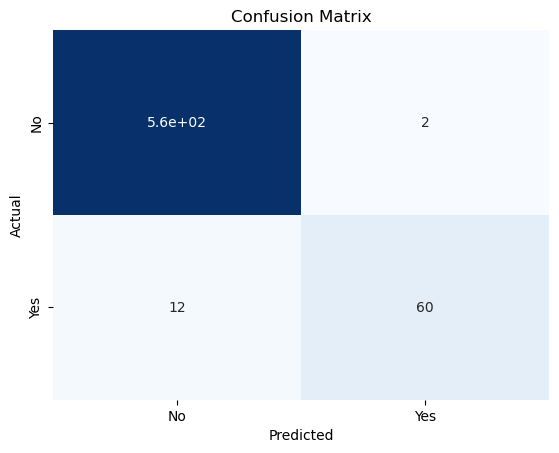

In [ ]:

print("Accuracy:", accuracy_score(qb_master_data['Pro Bowl'], qb_master_data['Pro Bowl Prediction']))
print(classification_report(qb_master_data['Pro Bowl'], qb_master_data['Pro Bowl Prediction']))

final_con_mat = confusion_matrix(qb_master_data['Pro Bowl'], qb_master_data['Pro Bowl Prediction'])


sns.heatmap(final_con_mat, cmap='Blues', annot=True, cbar=False, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

As displayed in the confusion matrix above the xgboost model performs exceptional well across the entire data set. With only two false positives, quarterbacks are rarely miss identified as a pro bowler. However there are 12 false negatives where a quarterback is not labeled as a Pro Bowler when they actually are. Lets examine the MVP winning quarterbacks to if any of them are false negatives. 

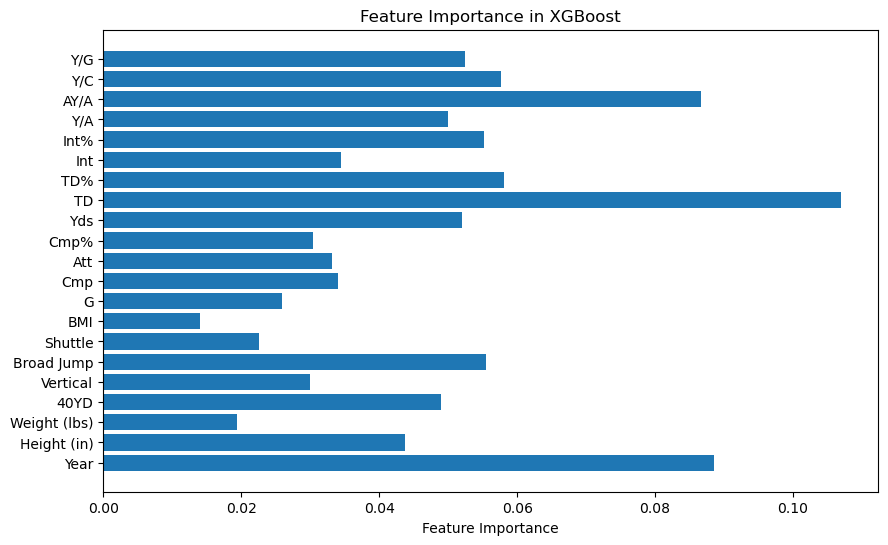

In [30]:
# Visualizing feature importances
import matplotlib.pyplot as plt

feature_importances = xgb_mod.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(qb_X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XGBoost')
plt.show()

We can see from this graph that the three features that have the most importance are Year, TDs, and Adjusted Yards per Attempt.

In [29]:
mvps = qb_master_data[qb_master_data['MVP'] == 'Yes']

print(mvps[['Name', 'Pro Bowl', 'Pro Bowl Prediction']].head(10))

                Name Pro Bowl Pro Bowl Prediction
48       Brett Favre      Yes                  No
154   Peyton Manning      Yes                 Yes
176        Tom Brady      Yes                 Yes
193       Drew Brees      Yes                 Yes
262    Aaron Rodgers      Yes                 Yes
318        Matt Ryan      Yes                 Yes
367       Cam Newton      Yes                 Yes
496  Patrick Mahomes      Yes                 Yes
506       Josh Allen      Yes                  No
520    Lamar Jackson      Yes                  No


Favre, Allen, and Jackson are three of the false positives, showing that while this model's performance is very strong it is not perfect. All of the other MVP's are correctly identified. With the optimal threshold of approxiamately 0.9233 we can see how a higher threshold works better with imbalanced data.  